In [1]:
# general purpose modules for handling data
import numpy as np
from numpy import array
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

# for loading telo data column containing individual
# telomere length values
from ast import literal_eval

# data visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# plot type I really like
from ptitprince import PtitPrince as pt

# custom module for handling telomere length data
import telomere_methods_astros as telo_ma

# statistics
import scipy.stats as stats
import scikit_posthocs as sp

In [2]:
# setting all graphs to have darkgrid style w/ black edges for axes elements

sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

## Analyzing Mean Telomere Lengths
---

### Reading in the data

In [3]:
astro_df = pd.read_csv('../excel data/All_astronauts_telomere_length_dataframe.csv')
astro_df['telo data'] = astro_df['telo data'].apply(lambda row: np.array(literal_eval(row)))
astro_df['astro id'] = astro_df['astro id'].astype('str')

In [ ]:
astro_df.head(4)

### Graphing / Stats Mean Telomere Lengths for 11 Astros

First.. let's see how mean telomere length changes w/ respect to spaceflight when all 11 astronauts are averaged together for pre-, mid-, & post-flight timepoints

Text(0, 0.5, 'Mean Telomere Length')

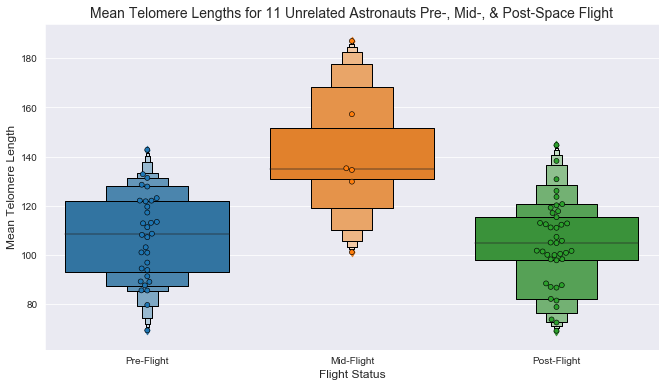

In [5]:
fig = plt.figure(figsize=(11,6))
ax = sns.boxenplot(x='flight status', y='telo means', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], data=astro_df)
ax = sns.swarmplot(x='flight status', y='telo means', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], data=astro_df,
                  linewidth=.6, edgecolor="black", dodge=True)

ax.set_title('Mean Telomere Lengths for 11 Unrelated Astronauts Pre-, Mid-, & Post-Space Flight', fontsize=14)
ax.set_xlabel('Flight Status', fontsize=12)
ax.set_ylabel('Mean Telomere Length', fontsize=12)

In [6]:
# one-way anova between mean telomere lengths per timepoint
pre_flight = astro_df[astro_df['flight status'] == 'Pre-Flight']['telo means']
mid_flight = astro_df[astro_df['flight status'] == 'Mid-Flight']['telo means']
post_flight = astro_df[astro_df['flight status'] == 'Post-Flight']['telo means']
                      
print(stats.f_oneway(pre_flight, mid_flight, post_flight))
sp.posthoc_ttest(astro_df, val_col='telo means', group_col='flight status', p_adjust='holm')

# I need to grab cell means for statistical tests; would be better for graphing as well?

F_onewayResult(statistic=10.31663691107309, pvalue=0.00010866812307219371)


,Pre-Flight,Mid-Flight,Post-Flight
Pre-Flight,-1.000000,0.000915,0.483015
Mid-Flight,0.000915,-1.000000,0.000202
Post-Flight,0.483015,0.000202,-1.000000


Mean telomere length increases as a function of spaceflight. Furthermore, mean telomere length for astronauts overall appears to be slightly shorter after spaceflight.. Let's see what telomere length looks like for just our astronauts w/ inflight data

### Graphing / Stats Mean Telomere lengths 3 Inflight Astros

In [7]:
only_mid_astros_df = astro_df[(astro_df['astro id'] == '5163') |
                              (astro_df['astro id'] == '1536') |
                              (astro_df['astro id'] == '2171')].copy()
only_mid_astros_df.shape

(24, 9)

Text(0.5, 1.0, 'Mean Telomere Lengths for 3 Unrelated Astronauts: Pre-, Mid-, Post-Flight')

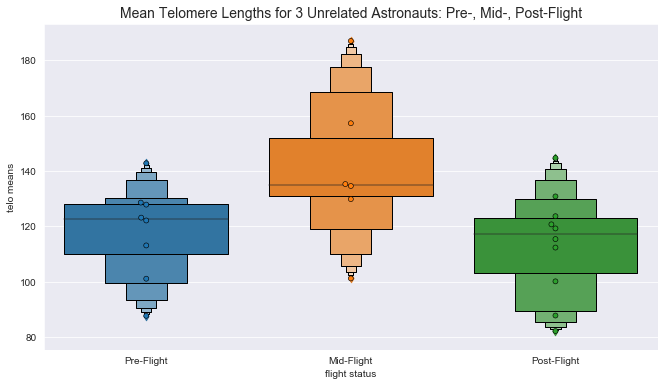

In [8]:
fig = plt.figure(figsize=(11,6))
ax = sns.boxenplot(x='flight status', y='telo means', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], data=only_mid_astros_df)
ax = sns.swarmplot(x='flight status', y='telo means', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], data=only_mid_astros_df,
                  linewidth=0.6, edgecolor='black')

ax.set_title('Mean Telomere Lengths for 3 Unrelated Astronauts: Pre-, Mid-, Post-Flight', fontsize=14)

In [9]:
# one-way anova between mean telomere lengths per timepoint

om_pre_flight = only_mid_astros_df[only_mid_astros_df['flight status'] == 'Pre-Flight']['telo means']
om_mid_flight = only_mid_astros_df[only_mid_astros_df['flight status'] == 'Mid-Flight']['telo means']
om_post_flight = only_mid_astros_df[only_mid_astros_df['flight status'] == 'Post-Flight']['telo means']
                      
# print(stats.f_oneway(om_pre_flight, om_mid_flight, om_post_flight))
# sp.posthoc_ttest(only_mid_astros_df, val_col='telo means', group_col='flight status', p_adjust='holm')

These 3 astronauts are our only individuals w/ inflight data, so the mid-flight mean telomere length has remained the same. The pre-/post-flight data has the same relationship compared to the data for all 11 astronauts: post-flight mean telomere length is *slightly* shorter.

Now.. our inflight astronauts had blood samples collected at different flight days. Let's first parse out the mean telomere length data per astronaut.

### Parsing Telomere Length @ Mid-Flight Dates for 3 Inflight Astros

Text(0.5, 1.0, 'Mean Telomere Lengths per Astronaut for 3 Unrelated Astronauts: Pre-, Mid-, Post-Flight')

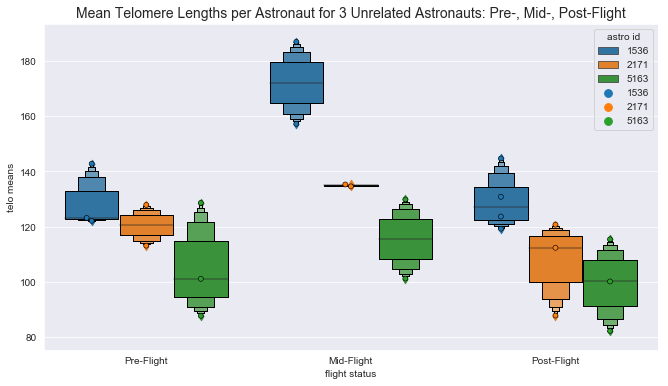

In [10]:
fig = plt.figure(figsize=(11,6))
ax = sns.boxenplot(x='flight status', y='telo means', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], hue='astro id', data=only_mid_astros_df, dodge=True)
ax = sns.swarmplot(x='flight status', y='telo means', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], hue='astro id', data=only_mid_astros_df,
                  linewidth=0.6, edgecolor='black', dodge=True)

ax.set_title('Mean Telomere Lengths per Astronaut for 3 Unrelated Astronauts: Pre-, Mid-, Post-Flight', fontsize=14)

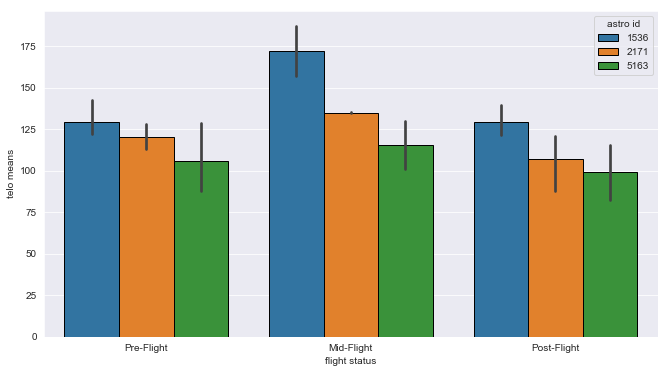

In [11]:
fig = plt.figure(figsize=(11,6))
ax = sns.barplot(x='flight status', y='telo means', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], hue='astro id', data=only_mid_astros_df, dodge=True)

Even when considered separately, for each astronaut the average of mean telomere length for their samples taken midflight was always longer than the average of samples pre-flight. As well, the average of mean telomere length for samples post-flight were slightly shorter. Interestingly, dso2171 looks to have similar mean telomere length for both blood draws.

Now we must consider if mean telomere length increases as a function of *duration in spaceflight*. We can do so b.c astros 1536&5163 samples were collected at FD90 & 140, while astro 2171 samples were collected at FD45 & 260. Let's first parse out the two mid-flight timepoints, then examine mid 1 & mid 2 for each astronaut

In [12]:
only_mid_astros_df['flight status mid split'] = only_mid_astros_df.loc[:, 'timepoint'].apply(lambda row: telo_ma.mid_split(row))

Text(0.5, 1.0, 'Mean Telomere Lengths for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight')

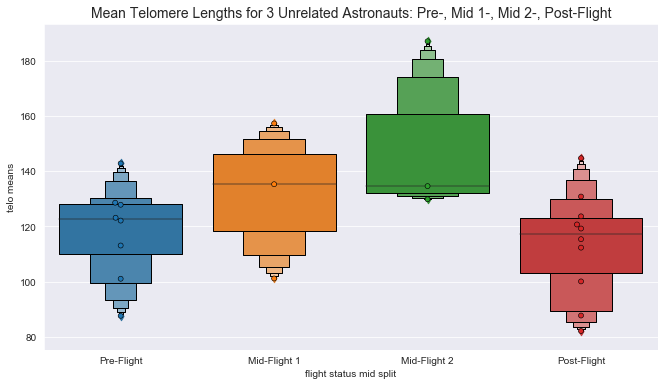

In [13]:
fig = plt.figure(figsize=(11,6))
ax = sns.boxenplot(x='flight status mid split', y='telo means', order=['Pre-Flight', 'Mid-Flight 1', 'Mid-Flight 2', 'Post-Flight'], data=only_mid_astros_df)
ax = sns.swarmplot(x='flight status mid split', y='telo means', order=['Pre-Flight', 'Mid-Flight 1', 'Mid-Flight 2', 'Post-Flight'], data=only_mid_astros_df,
                  linewidth=0.6, edgecolor='black')

ax.set_title('Mean Telomere Lengths for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight', fontsize=14)

The average of mean telomere lengths for mid-flight 2 is certainly higher than for mid-flight 1. There may be some relationship between telomere lengthening and spaceflight duration. However, telomere length does appear to have a biological upper bounds for species, though numerically undefined, thus it's unlikely that telomere length would increase indefinitely via spaceflight. Let's see how the data looks per astronaut.

Text(0.5, 1.0, 'Mean Telomere Lengths per Astronaut for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight')

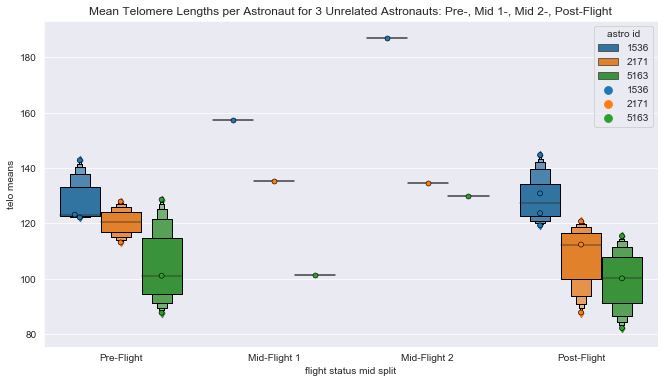

In [14]:
fig = plt.figure(figsize=(11,6))
ax = sns.boxenplot(x='flight status mid split', y='telo means', order=['Pre-Flight', 'Mid-Flight 1', 'Mid-Flight 2', 'Post-Flight'], 
                   hue='astro id', data=only_mid_astros_df, dodge=True)
ax = sns.swarmplot(x='flight status mid split', y='telo means', order=['Pre-Flight', 'Mid-Flight 1', 'Mid-Flight 2', 'Post-Flight'], 
                   hue='astro id', data=only_mid_astros_df,
                  linewidth=0.6, edgecolor='black', dodge=True)

ax.set_title('Mean Telomere Lengths per Astronaut for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight')

Astros 1536 & 5163 blood draws occured at FD90 & FD140, and both experienced an increase in mean telomere length at mid-flight 1 relative to pre-flight, and experienced an additional increase over mid-flight 1 at mid0flight 2.

Astro 2171 had blood draws at FD45 & FD260, and while mid-flight 1 had increased mean telomere length relative to pre-flight, mid-flight 2 was not. Rather, mid-flight 2 was numerically close to mid-flight 1. Altogether, mean telomere length does not appear to increase indefinitely with spaceflight. Our limited # of datapoints suggest that while mean telomere length increases mid-flight, it does not increase indefinitely.

Let's look at individual telomere lengths.

## Analyzing Individual Telomere Length Distributions

### Reading in the data

In [15]:
exploded_telos_astro_df = pd.read_csv('../excel data/exploded_telos_astros_df.csv')
exploded_telos_astro_df['astro id'] = exploded_telos_astro_df['astro id'].astype('str')

exploded_telos_astro_df.head(4)

,astro number,astro id,timepoint,flight status,telo means,telo data exploded
0,1,5163,L-270,Pre-Flight,87.672120,46.976278
1,1,5163,L-180,Pre-Flight,101.077756,102.388907
2,1,5163,L-60,Pre-Flight,128.599235,92.432342
3,1,5163,FD90,Mid-Flight,101.183129,89.224858


### Grabbing Individual Telomere Lengths 3 Inflight Astros

In [16]:
exploded_telos_only_mid_astros_df = exploded_telos_astro_df[(exploded_telos_astro_df['astro id'] == '5163') |
                              (exploded_telos_astro_df['astro id'] == '1536') |
                              (exploded_telos_astro_df['astro id'] == '2171')].copy()

exploded_telos_only_mid_astros_df.shape

(132480, 6)

In [17]:
exploded_telos_only_mid_astros_df['flight status mid split'] = exploded_telos_only_mid_astros_df['timepoint'].apply(lambda row: telo_ma.mid_split(row))

We've seen that mean telomere length increases during spaceflight. Now let us define short&long telomeres and visualize individual telomere length distributions per astronaut for timepoints most distal to spaceflight. 

To define short & long telomeres, we'll first find the earliest pre-flight samples for each astronaut. Then, in the individual telomere length distribution for that sample, we'll find the quartile boundary values for the bottom 25% of telos (short telos), middle 50%, and top 25% (long telos). The short, medium, and long telomeres will be colored yellow, blue, and pink respectively.

Once the quartile boundary values are established by the earliest pre-flight timepoint, the quartile boundary values will be used to color both midflight samples and the latest post-flight sample. In doing so, we can visualize and quantify the shifts of short/mid/long telomeres for each sample relative to the earliest timepoint. Now we have a means to discuss these classes of telomeres.

### Graphing Individual Telo Distributions 3 Inflight Astros

In [18]:
import importlib
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [19]:
%reload_ext autoreload

In [20]:
exploded_telos_only_mid_astros_df['astro id'] = exploded_telos_only_mid_astros_df['astro id'].astype('str')
telo_ma.make_histograms_colored_by_quartile_for_astronauts(exploded_telos_only_mid_astros_df)

Error in callback <function flush_figures at 0x11b5ed7a0> (for post_execute):


KeyboardInterrupt: 

Intriguingly, we see a *decrease* in short telos and an *increase* in long telos inflight. Furthermore, 2/3 astronauts experienced a remarkable increase in short telomeres post-flight. Now, let us quantify and visualize the #s of short/medium/long telomeres for the complete timecourse for these 3 unrelated astronauts.

In [21]:
melted_quartiles_astro_df = pd.read_csv('../excel data/melted_quartiles_astro_df.csv')

In [22]:
melted_quartiles_astro_df['astro id'] = melted_quartiles_astro_df['astro id'].astype('str')
melted_quartiles_astro_df.head(4)

,astro number,astro id,timepoint,flight status,telo data,telo means,relative Q,Q freq counts
0,1,5163,L-270,Pre-Flight,"[46.9762779819579, 78.38289341797528, 105.1119...",87.672120,Q1,1384
1,1,5163,L-180,Pre-Flight,"[102.38890745071835, 107.3170731707317, 61.944...",101.077756,Q1,848
2,1,5163,L-60,Pre-Flight,"[92.4323421316405, 144.537253591714, 135.59973...",128.599235,Q1,259
3,1,5163,FD90,Mid-Flight,"[89.22485800200468, 116.6388239224858, 116.221...",101.183129,Q1,472


In [23]:
mid_only_melted_quartiles_astro_df = melted_quartiles_astro_df[(melted_quartiles_astro_df['astro id'] == '5163') |
                              (melted_quartiles_astro_df['astro id'] == '1536') |
                              (melted_quartiles_astro_df['astro id'] == '2171')].copy()

distal_mid_only_melted_quartiles_astro_df = mid_only_melted_quartiles_astro_df
distal_mid_only_melted_quartiles_astro_df = mid_only_melted_quartiles_astro_df[(mid_only_melted_quartiles_astro_df['timepoint'] != 'L-60') &
                                                                               (mid_only_melted_quartiles_astro_df['timepoint'] != 'R+60') &
                                                                               (mid_only_melted_quartiles_astro_df['timepoint'] != 'R+7') & 
                                                                               (mid_only_melted_quartiles_astro_df['timepoint'] != 'R+5')].copy()

distal_mid_only_melted_quartiles_astro_df.head(5)

,astro number,astro id,timepoint,flight status,telo data,telo means,relative Q,Q freq counts
0,1,5163,L-270,Pre-Flight,"[46.9762779819579, 78.38289341797528, 105.1119...",87.672120,Q1,1384
1,1,5163,L-180,Pre-Flight,"[102.38890745071835, 107.3170731707317, 61.944...",101.077756,Q1,848
3,1,5163,FD90,Mid-Flight,"[89.22485800200468, 116.6388239224858, 116.221...",101.183129,Q1,472
4,1,5163,FD140,Mid-Flight,"[161.89442031406617, 152.82325425993986, 223.3...",129.851970,Q1,203
7,1,5163,R+180,Post-Flight,"[163.46475108586702, 157.11660541262947, 75.76...",115.403190,Q1,936


Text(0, 0.5, 'Individual Telos Freqs Within first time point Quartiles')

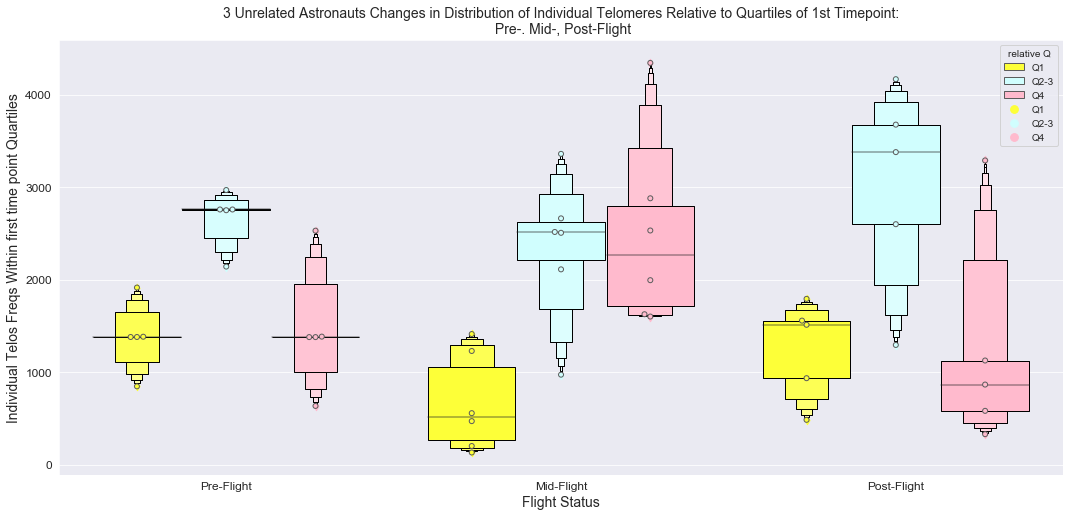

In [ ]:
fig = plt.figure(figsize=(18,8))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

ax = sns.boxenplot(x='flight status', y='Q freq counts', hue='relative Q', data=distal_mid_only_melted_quartiles_astro_df, palette=palette,
             linewidth=2, saturation=5, color="black")
ax = sns.swarmplot(x='flight status', y='Q freq counts', hue='relative Q', data=distal_mid_only_melted_quartiles_astro_df, palette=palette,
             linewidth=1, color="black", dodge=True)

ax=fig.gca()
ax.set_title('3 Unrelated Astronauts Changes in Distribution of Individual Telomeres Relative to Quartiles of 1st Timepoint:\n Pre-. Mid-, Post-Flight', fontsize=14)
ax.set_xlabel('Flight Status', fontsize=14)
ax.set_ylabel('Individual Telos Freqs Within first time point Quartiles', fontsize=14)

In [ ]:
distal_mid_only_melted_quartiles_astro_df['flight status mid split'] = (distal_mid_only_melted_quartiles_astro_df['timepoint']
                                                                                .apply(lambda row: telo_ma.mid_split(row)))


Text(0, 0.5, 'Individual Telos Freqs Within first time point Quartiles')

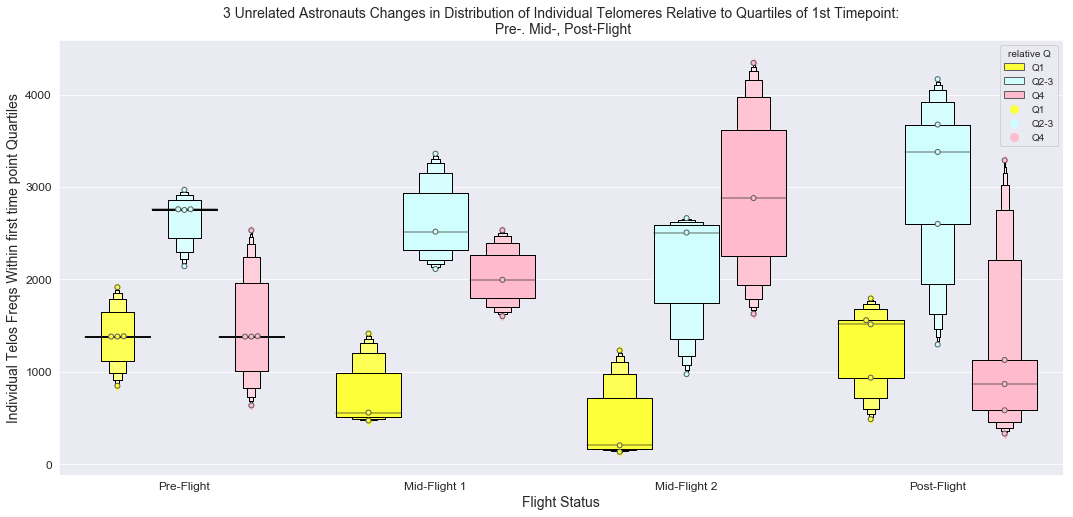

In [ ]:
fig = plt.figure(figsize=(18,8))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

ax = sns.boxenplot(x='flight status mid split', y='Q freq counts', hue='relative Q', data=distal_mid_only_melted_quartiles_astro_df, palette=palette,
             linewidth=2, saturation=5, color="black")
ax = sns.swarmplot(x='flight status mid split', y='Q freq counts', hue='relative Q', data=distal_mid_only_melted_quartiles_astro_df, palette=palette,
             linewidth=1, color="black", dodge=True)

ax=fig.gca()
ax.set_title('3 Unrelated Astronauts Changes in Distribution of Individual Telomeres Relative to Quartiles of 1st Timepoint:\n Pre-. Mid-, Post-Flight', fontsize=14)
ax.set_xlabel('Flight Status', fontsize=14)
ax.set_ylabel('Individual Telos Freqs Within first time point Quartiles', fontsize=14)

In [ ]:
# import matplotlib.patheffects as mpe

# sns.set_style(style="darkgrid",rc={'patch.edgecolor': 'black'})
# palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

# sns.catplot(x='flight status', y='Q freq counts', hue='relative Q', col='astro id', col_order=['5163', '1536', '2171'], height=8, aspect=1,
#            data=distal_mid_only_melted_quartiles_astro_df, kind='point', dodge=True,
#             **{'markers': ['D', 'D', 'D'], 'scale': 3,})

In [ ]:
# sns.set_style(style="darkgrid",rc={'patch.edgecolor': 'black'})
# palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

# sns.catplot(x='flight status mid split', y='Q freq counts', hue='relative Q', col='astro id', col_order=['5163', '1536', '2171'], height=8, aspect=1,
#            data=distal_mid_only_melted_quartiles_astro_df, kind='point', dodge=True,
#             **{'markers': ['D', 'D', 'D'], 'scale': 3,})

In [ ]:
distal_melted_quartiles_astro_df = melted_quartiles_astro_df[(melted_quartiles_astro_df['timepoint'] != 'L-60') &
                                                             (melted_quartiles_astro_df['timepoint'] != 'R+5') &
                                                             (melted_quartiles_astro_df['timepoint'] != 'R+7') &
                                                             (melted_quartiles_astro_df['timepoint'] !='R+60')].copy()

Text(0, 0.5, 'Individual Telos Freqs Within first time point Quartiles')

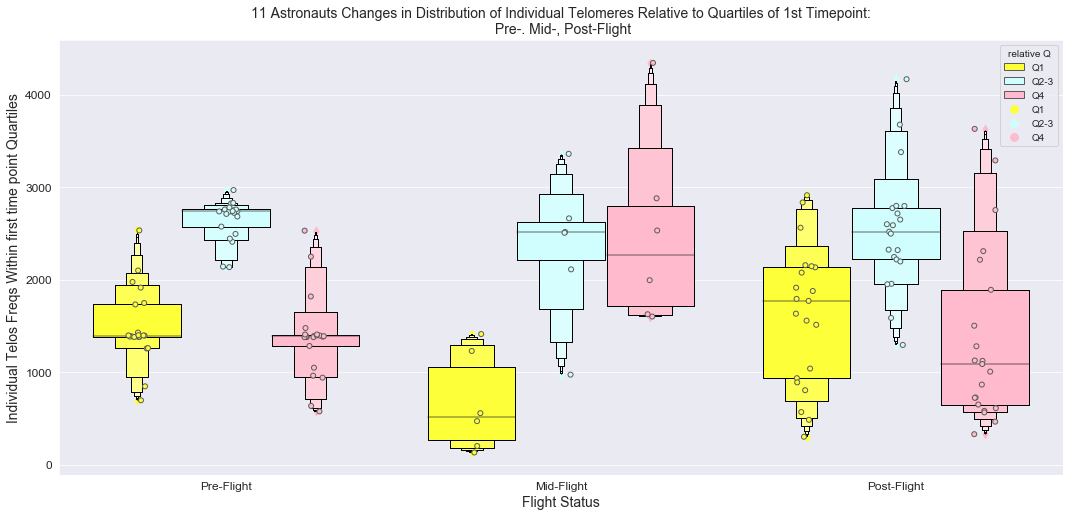

In [ ]:
fig = plt.figure(figsize=(18,8))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

ax = sns.boxenplot(x='flight status', y='Q freq counts', hue='relative Q', data=distal_melted_quartiles_astro_df, palette=palette,
             linewidth=2, saturation=5, color="black")
ax = sns.stripplot(x='flight status', y='Q freq counts', hue='relative Q', data=distal_melted_quartiles_astro_df, palette=palette,
             linewidth=1, color="black", dodge=True)

ax=fig.gca()
ax.set_title('11 Astronauts Changes in Distribution of Individual Telomeres Relative to Quartiles of 1st Timepoint:\n Pre-. Mid-, Post-Flight', fontsize=14)
ax.set_xlabel('Flight Status', fontsize=14)
ax.set_ylabel('Individual Telos Freqs Within first time point Quartiles', fontsize=14)

In [ ]:
%reload_ext autoreload

In [ ]:
telo_ma.make_histograms_colored_by_quartile_for_astronauts(exploded_telos_astro_df)

### Making all controls individual telomere length histogram

In [ ]:
all_controls_df = pd.read_csv('../excel data/All_astro_controls_telomere_length_dataframe.csv')
all_controls_df['telo data'] = all_controls_df['telo data'].apply(lambda row: np.array(literal_eval(row)))

all_controls_df.drop('flight status', axis=1, inplace=True)
print(all_controls_df.shape)
all_controls_df.head(4)

In [ ]:
explode_ctrl_telos_raw = all_controls_df['telo data'].apply(pd.Series)
exploded_telos_control_df = (explode_ctrl_telos_raw

    .merge(all_controls_df, right_index = True, left_index = True)                  
    .drop('telo data', axis=1)
    .melt(id_vars = ['control id', 'timepoint', 'flight status controls', 'telo means'], value_name = "telo data exploded") 
    .drop("variable", axis = 1)
    .dropna())

exploded_telos_control_df.shape

In [ ]:
exploded_telos_control_df = exploded_telos_control_df[(exploded_telos_control_df['timepoint'] != 'R+7') &
                          (exploded_telos_control_df['timepoint'] != 'R+5')]

exploded_telos_control_df['flight status controls'].value_counts()

In [ ]:
quartile_reference = exploded_telos_control_df[exploded_telos_control_df['flight status controls'] == 'Pre-Flight']['telo data exploded']
pre_f = exploded_telos_control_df[exploded_telos_control_df['flight status controls'] == 'Pre-Flight']['telo data exploded']
post_f = exploded_telos_control_df[exploded_telos_control_df['flight status controls'] == 'Post-Flight']['telo data exploded']

In [ ]:
%reload_ext autoreload

In [ ]:
n_bins = 80

telo_ma.graph_two_histograms(quartile_reference, n_bins, pre_f, post_f,
                                       'Controls Pre-Flight', 'Controls Post-Flight', controls=True)

plt.savefig(f'../individual telomere length histogram distributions/png/ALL CONTROLS histogram of individual telomere length distributions.png', dpi=600)
plt.savefig(f'../individual telomere length histogram distributions/svg/ALL CONTROLS histogram of individual telomere length distributions.svg', format='svg', dpi=1500)

## Urine/Blood Biochemistry Data 
___

### Reading in urine analyte data

In [20]:
melt_urine_biochem_data = pd.read_csv('../excel data/melt_urine_biochem_data.csv')

### Merging telomere length / urine biochemistry data

In [21]:
# grouping urine biochem data by flight status & biochemistry test & taking mean of timepoints

group_melt_urine_biochem_data = melt_urine_biochem_data.groupby(['flight status', 'biochemistry analyte']).agg('mean').reset_index()
group_melt_urine_biochem_data.head()

,flight status,biochemistry analyte,measured analyte
0,Mid-Flight,"8-OHdG, Urine ug/gCr",3.040
1,Mid-Flight,"Copper, Urine umol/day",0.224
2,Mid-Flight,PGF2-alpha ng/mg Cr,2.688
3,Mid-Flight,"Selenium, Urine umol/day",1.156
4,Post-Flight,"8-OHdG, Urine ug/gCr",2.075


In [22]:
# grouping astronaut data by flight status and taking mean

trim_astro_df = astro_df.drop(['astro number', 'telo data', 'Q1', 'Q2-3', 'Q4'], axis=1)
group_astros_telos = trim_astro_df.groupby('flight status').agg('mean').reset_index()

In [23]:
# analytes grouped as mean & astro telos grouped as mean
merge_grouped_urine_telos = group_melt_urine_biochem_data.merge(group_astros_telos, on='flight status')

# analyes not grouped as mean, astrou telos grouped as mean
merge_urine_telos = melt_urine_biochem_data.merge(group_astros_telos, on='flight status')

In [24]:
sorter = ['Pre-Flight', 'Mid-Flight', 'Post-Flight']

merge_grouped_urine_telos['flight status'] = merge_grouped_urine_telos['flight status'].astype('category')
merge_grouped_urine_telos['flight status'].cat.set_categories(sorter, inplace=True)
merge_grouped_urine_telos = merge_grouped_urine_telos.sort_values('flight status').reset_index(drop=True)

In [25]:
merge_grouped_urine_telos.head(4)

,flight status,biochemistry analyte,measured analyte,telo means
0,Pre-Flight,"8-OHdG, Urine ug/gCr",2.60,107.288598
1,Pre-Flight,"Copper, Urine umol/day",0.28,107.288598
2,Pre-Flight,PGF2-alpha ng/mg Cr,1.84,107.288598
3,Pre-Flight,"Selenium, Urine umol/day",1.02,107.288598


In [26]:
merge_grouped_urine_telos.rename(columns={'telo means':'Mean Telomere Length'}, inplace=True)
merge_urine_telos.rename(columns={'telo means':'Mean Telomere Length'}, inplace=True)

In [27]:
alpha = merge_grouped_urine_telos.groupby('biochemistry analyte')

### Analyzing Correlations between Urine Analytes & Mean Telomere Length

In [28]:
# analytes grouped as means (pre, mid, post) correlated w/ mean telo length (pre, mid, post)

for group in list(merge_grouped_urine_telos['biochemistry analyte'].unique()):
    print(group)
    print(alpha.get_group(group).corr()['Mean Telomere Length'][0], '\n')

8-OHdG, Urine ug/gCr
0.8763225786238364 

Copper, Urine umol/day
-0.8553730109572085 

PGF2-alpha ng/mg Cr
0.9970805104031575 

Selenium, Urine umol/day
0.9664254217154524 



In [29]:
# analytes retaining blood draw day correlated w/ mean telo length (pre, mid, post); provides more timepoints for corr

beta = merge_urine_telos.groupby('biochemistry analyte')

for group in list(merge_urine_telos['biochemistry analyte'].unique()):
    print(group)
    print(beta.get_group(group).corr()['Mean Telomere Length'][0], '\n')

8-OHdG, Urine ug/gCr
0.7825680564008605 

Copper, Urine umol/day
-0.5648597127987169 

PGF2-alpha ng/mg Cr
0.8972566156801102 

Selenium, Urine umol/day
0.8549587491041589 



In [30]:
merge_urine_telos.head(6)

,biochemistry analyte,sample type,timepoint,measurement,flight status,measured analyte,Mean Telomere Length
0,"8-OHdG, Urine ug/gCr",urine,Pre,2.6 ± 1,Pre-Flight,2.60,107.288598
1,"Copper, Urine umol/day",urine,Pre,0.28 ± 0.17,Pre-Flight,0.28,107.288598
2,PGF2-alpha ng/mg Cr,urine,Pre,1.84 ± 1.2,Pre-Flight,1.84,107.288598
3,"Selenium, Urine umol/day",urine,Pre,1.02 ± 0.39,Pre-Flight,1.02,107.288598
4,"8-OHdG, Urine ug/gCr",urine,FD15,3.1 ± 1,Mid-Flight,3.10,140.872973
5,"Copper, Urine umol/day",urine,FD15,0.24 ± 0.04,Mid-Flight,0.24,140.872973


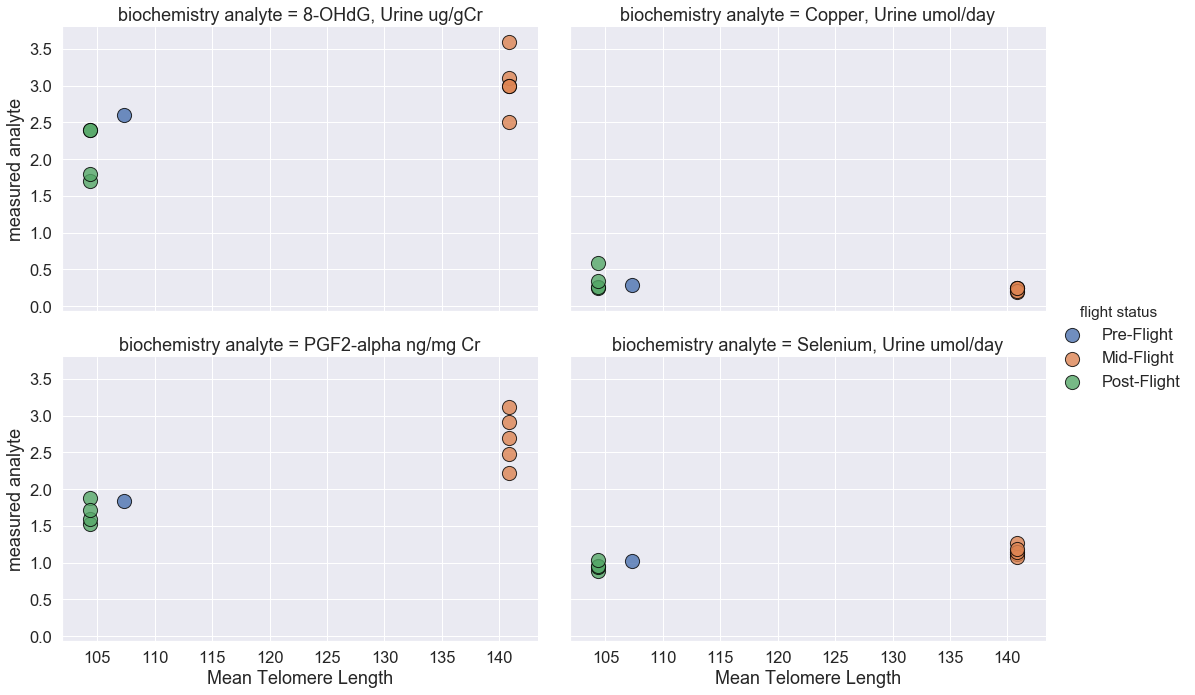

In [20]:
ax = sns.set(font_scale=1.5)
ax = sns.lmplot(x='Mean Telomere Length', y='measured analyte', hue='flight status', 
                col='biochemistry analyte', col_wrap=2,
                data=merge_urine_telos,
                fit_reg=False, scatter_kws={'s':200, 'edgecolor':'black', 'linewidth':1},
                height=5, aspect=1.5,
                hue_order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'],
          )

ax.savefig('graph data/biochemistry correlations/scatterplot correlations urine analytes mean telomere length.png', dpi=400)

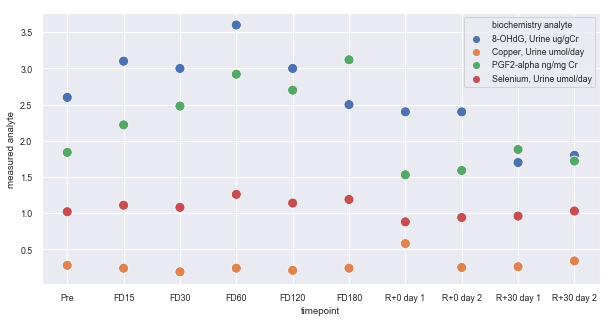

In [129]:
ax = sns.set(font_scale=.8)
plt.figure(figsize=(10,5))
ax = sns.scatterplot(x='timepoint', y='measured analyte', hue='biochemistry analyte', 
                data=merge_urine_telos, s=100)


In [180]:
# deprecated bar graph of analytes

# ax = sns.catplot(x='flight status', y='measured analyte', data=merge_urine_telos[merge_urine_telos['biochemistry analyte'] != 'Copper, Urine umol/day'],
#            col='biochemistry analyte', col_wrap=3, kind='bar', sharey=False, ci='sd')

# fig = ax.fig
# fig.suptitle('Astornaut Urine Biochemistry Analytes of High Correlations w/ Mean Telomere Length (>|0.7|)', weight='bold', fontsize=15)
# plt.subplots_adjust(top=0.85)
# ax.set_titles(size=12)

# ax.savefig('./graph data/biochemistry correlations/Astronaut Urine Biochemistry Analytes of High Correlations with Mean Telomere Length.png')

### Reading in blood analyte data

In [4]:
melt_blood_biochem_data = pd.read_csv('../excel data/melt_blood_biochem_data.csv')
melt_blood_biochem_data.head(4)

,biochemistry analyte,sample type,timepoint,measurement,flight status,measured analyte
0,CCL2/MCP-1 pg/ml,blood,Pre,83 ± 17,Pre-Flight,83.0
1,CCL3/MIP-1a pg/ml,blood,Pre,438 ± 194,Pre-Flight,438.0
2,CCL4/MIP1B pg/ml,blood,Pre,54 ± 17,Pre-Flight,54.0
3,CCL5/RANTES pg/ml,blood,Pre,6902 ± 4393,Pre-Flight,6902.0


In [5]:
group_melt_blood_biochem_data = melt_blood_biochem_data.groupby(['flight status', 'biochemistry analyte']).agg('mean').reset_index()

In [6]:
group_melt_blood_biochem_data.head(4)

,flight status,biochemistry analyte,measured analyte
0,Mid-Flight,CCL2/MCP-1 pg/ml,93.6
1,Mid-Flight,CCL3/MIP-1a pg/ml,613.6
2,Mid-Flight,CCL4/MIP1B pg/ml,79.2
3,Mid-Flight,CCL5/RANTES pg/ml,15266.6


In [7]:
trim_astro_df = astro_df.drop(['astro number', 'telo data', 'Q1', 'Q2-3', 'Q4'], axis=1)
group_astros_telos = trim_astro_df.groupby('flight status').agg('mean').reset_index()

### Merging telomere length / blood biochemistry data

In [8]:
# blood analytes grouped by mean merged w/ mean telos
merge_grouped_blood_telos = group_melt_blood_biochem_data.merge(group_astros_telos, on='flight status')

In [9]:
sorter = ['Pre-Flight', 'Mid-Flight', 'Post-Flight']

merge_grouped_blood_telos['flight status'] = merge_grouped_blood_telos['flight status'].astype('category')
merge_grouped_blood_telos['flight status'].cat.set_categories(sorter, inplace=True)
merge_grouped_blood_telos = merge_grouped_blood_telos.sort_values('flight status').reset_index(drop=True)

In [10]:
merge_grouped_blood_telos.head(4)

,flight status,biochemistry analyte,measured analyte,telo means
0,Pre-Flight,hs CRP mg/L,1.15,107.288598
1,Pre-Flight,"Glutathione, Total umol/L",1266.00,107.288598
2,Pre-Flight,"Glutathione, Oxidized umol/L",225.00,107.288598
3,Pre-Flight,GPX U/g Hgb,45.00,107.288598


In [11]:
# blood analytes not grouped by mean merged w/ mean telos
merge_blood_telos = melt_blood_biochem_data.merge(group_astros_telos, on = 'flight status')


# seems more sensible to correlate average telomere length @ pre/mid/post with analytes at each of their timepoints,
# b.c provides more timepoints to correlate w/

In [12]:
merge_blood_telos.rename(columns={'telo means':'Mean Telomere Length'}, inplace=True)
merge_blood_telos.head(4)

,biochemistry analyte,sample type,timepoint,measurement,flight status,measured analyte,Mean Telomere Length
0,CCL2/MCP-1 pg/ml,blood,Pre,83 ± 17,Pre-Flight,83.0,107.288598
1,CCL3/MIP-1a pg/ml,blood,Pre,438 ± 194,Pre-Flight,438.0,107.288598
2,CCL4/MIP1B pg/ml,blood,Pre,54 ± 17,Pre-Flight,54.0,107.288598
3,CCL5/RANTES pg/ml,blood,Pre,6902 ± 4393,Pre-Flight,6902.0,107.288598


In [13]:
pivot_merge_blood_telos = merge_blood_telos.pivot_table(index=['timepoint', 'sample type', 'flight status', 'Mean Telomere Length'], 
                                                        columns='biochemistry analyte', values='measured analyte').reset_index()

pivot_merge_blood_telos.to_csv('../excel data/pivot_merge_blood_telos.csv', index=False)

In [45]:
pivot_merge_blood_telos.head(4)

biochemistry analyte,timepoint,sample type,flight status,Mean Telomere Length,CCL2/MCP-1 pg/ml,CCL3/MIP-1a pg/ml,CCL4/MIP1B pg/ml,CCL5/RANTES pg/ml,CXCL5/ENA-78 pg/ml,CXCL8/IL-8 pg/ml,...,Superoxide Dismutase U/g Hgb,Total Antioxidant Capacity mmol/L,Total Lipid Peroxides umol/L,Transferrin Receptors ug/mL,Transferrin mg/dL,VEGF-1 Immune Lab pg/ml,Vitamin B12 pmol/L,Vitamin C ug/mL,"Zinc, Serum umol/L",hs CRP mg/L
0,FD120,blood,Mid-Flight,140.872973,96.0,489.0,75.0,14227.0,1009.0,12.0,...,NaN,1.50,NaN,4.6,232.0,433.0,333.0,NaN,16.9,0.85
1,FD15,blood,Mid-Flight,140.872973,89.0,644.0,75.0,15462.0,1233.0,23.0,...,NaN,1.57,NaN,3.7,247.0,369.0,334.0,NaN,16.5,0.85
2,FD180,blood,Mid-Flight,140.872973,93.0,641.0,70.0,13636.0,919.0,19.0,...,NaN,1.49,NaN,4.4,247.0,338.0,304.0,NaN,15.7,0.72
3,FD30,blood,Mid-Flight,140.872973,94.0,652.0,101.0,17986.0,1005.0,14.0,...,NaN,1.47,NaN,4.1,213.0,590.0,246.0,NaN,16.2,0.37


In [46]:
drop_na_pivot_merge_blood_telos = pivot_merge_blood_telos.dropna(axis=1)

In [47]:
drop_melt_merge_blood_telos = drop_na_pivot_merge_blood_telos.melt(id_vars=['timepoint', 'sample type', 'flight status', 'Mean Telomere Length'], 
                                var_name='biochemistry analyte', value_name='measured analyte').reset_index(drop=True)
drop_melt_merge_blood_telos.head(4)

,timepoint,sample type,flight status,Mean Telomere Length,biochemistry analyte,measured analyte
0,FD120,blood,Mid-Flight,140.872973,CCL2/MCP-1 pg/ml,96.0
1,FD15,blood,Mid-Flight,140.872973,CCL2/MCP-1 pg/ml,89.0
2,FD180,blood,Mid-Flight,140.872973,CCL2/MCP-1 pg/ml,93.0
3,FD30,blood,Mid-Flight,140.872973,CCL2/MCP-1 pg/ml,94.0


## Data example

In [48]:
grouped = drop_melt_merge_blood_telos.groupby(['biochemistry analyte'])
il_4_group = grouped.get_group('IL-4 pg/ml').copy()
il_4_group

,timepoint,sample type,flight status,Mean Telomere Length,biochemistry analyte,measured analyte
136,FD120,blood,Mid-Flight,140.872973,IL-4 pg/ml,93.0
137,FD15,blood,Mid-Flight,140.872973,IL-4 pg/ml,90.0
138,FD180,blood,Mid-Flight,140.872973,IL-4 pg/ml,87.0
139,FD30,blood,Mid-Flight,140.872973,IL-4 pg/ml,109.0
140,FD60,blood,Mid-Flight,140.872973,IL-4 pg/ml,91.0
141,Pre,blood,Pre-Flight,107.288598,IL-4 pg/ml,65.0
142,R+0,blood,Post-Flight,104.379082,IL-4 pg/ml,55.0
143,R+180,blood,Post-Flight,104.379082,IL-4 pg/ml,60.0


In [49]:
sorter = ['Pre', 'FD15', 'FD30', 'FD60', 'FD120', 'FD180', 'R+0', 'R+180']
il_4_group['timepoint'] = il_4_group['timepoint'].astype('category')
il_4_group['timepoint'].cat.set_categories(sorter, inplace=True)

il_4_group = il_4_group.sort_values('timepoint').reset_index(drop=True).copy()
il_4_group

,timepoint,sample type,flight status,Mean Telomere Length,biochemistry analyte,measured analyte
0,Pre,blood,Pre-Flight,107.288598,IL-4 pg/ml,65.0
1,FD15,blood,Mid-Flight,140.872973,IL-4 pg/ml,90.0
2,FD30,blood,Mid-Flight,140.872973,IL-4 pg/ml,109.0
3,FD60,blood,Mid-Flight,140.872973,IL-4 pg/ml,91.0
4,FD120,blood,Mid-Flight,140.872973,IL-4 pg/ml,93.0
5,FD180,blood,Mid-Flight,140.872973,IL-4 pg/ml,87.0
6,R+0,blood,Post-Flight,104.379082,IL-4 pg/ml,55.0
7,R+180,blood,Post-Flight,104.379082,IL-4 pg/ml,60.0


In [50]:
merge_urine_telos.to_excel('../excel data/merge_urine_telos.xlsx', index=False)
drop_melt_merge_blood_telos.to_excel('../excel data/drop_melt_merge_blood_telos.xlsx', index=False)

NameError: name 'merge_urine_telos' is not defined

In [19]:
from scipy.stats import pearsonr

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

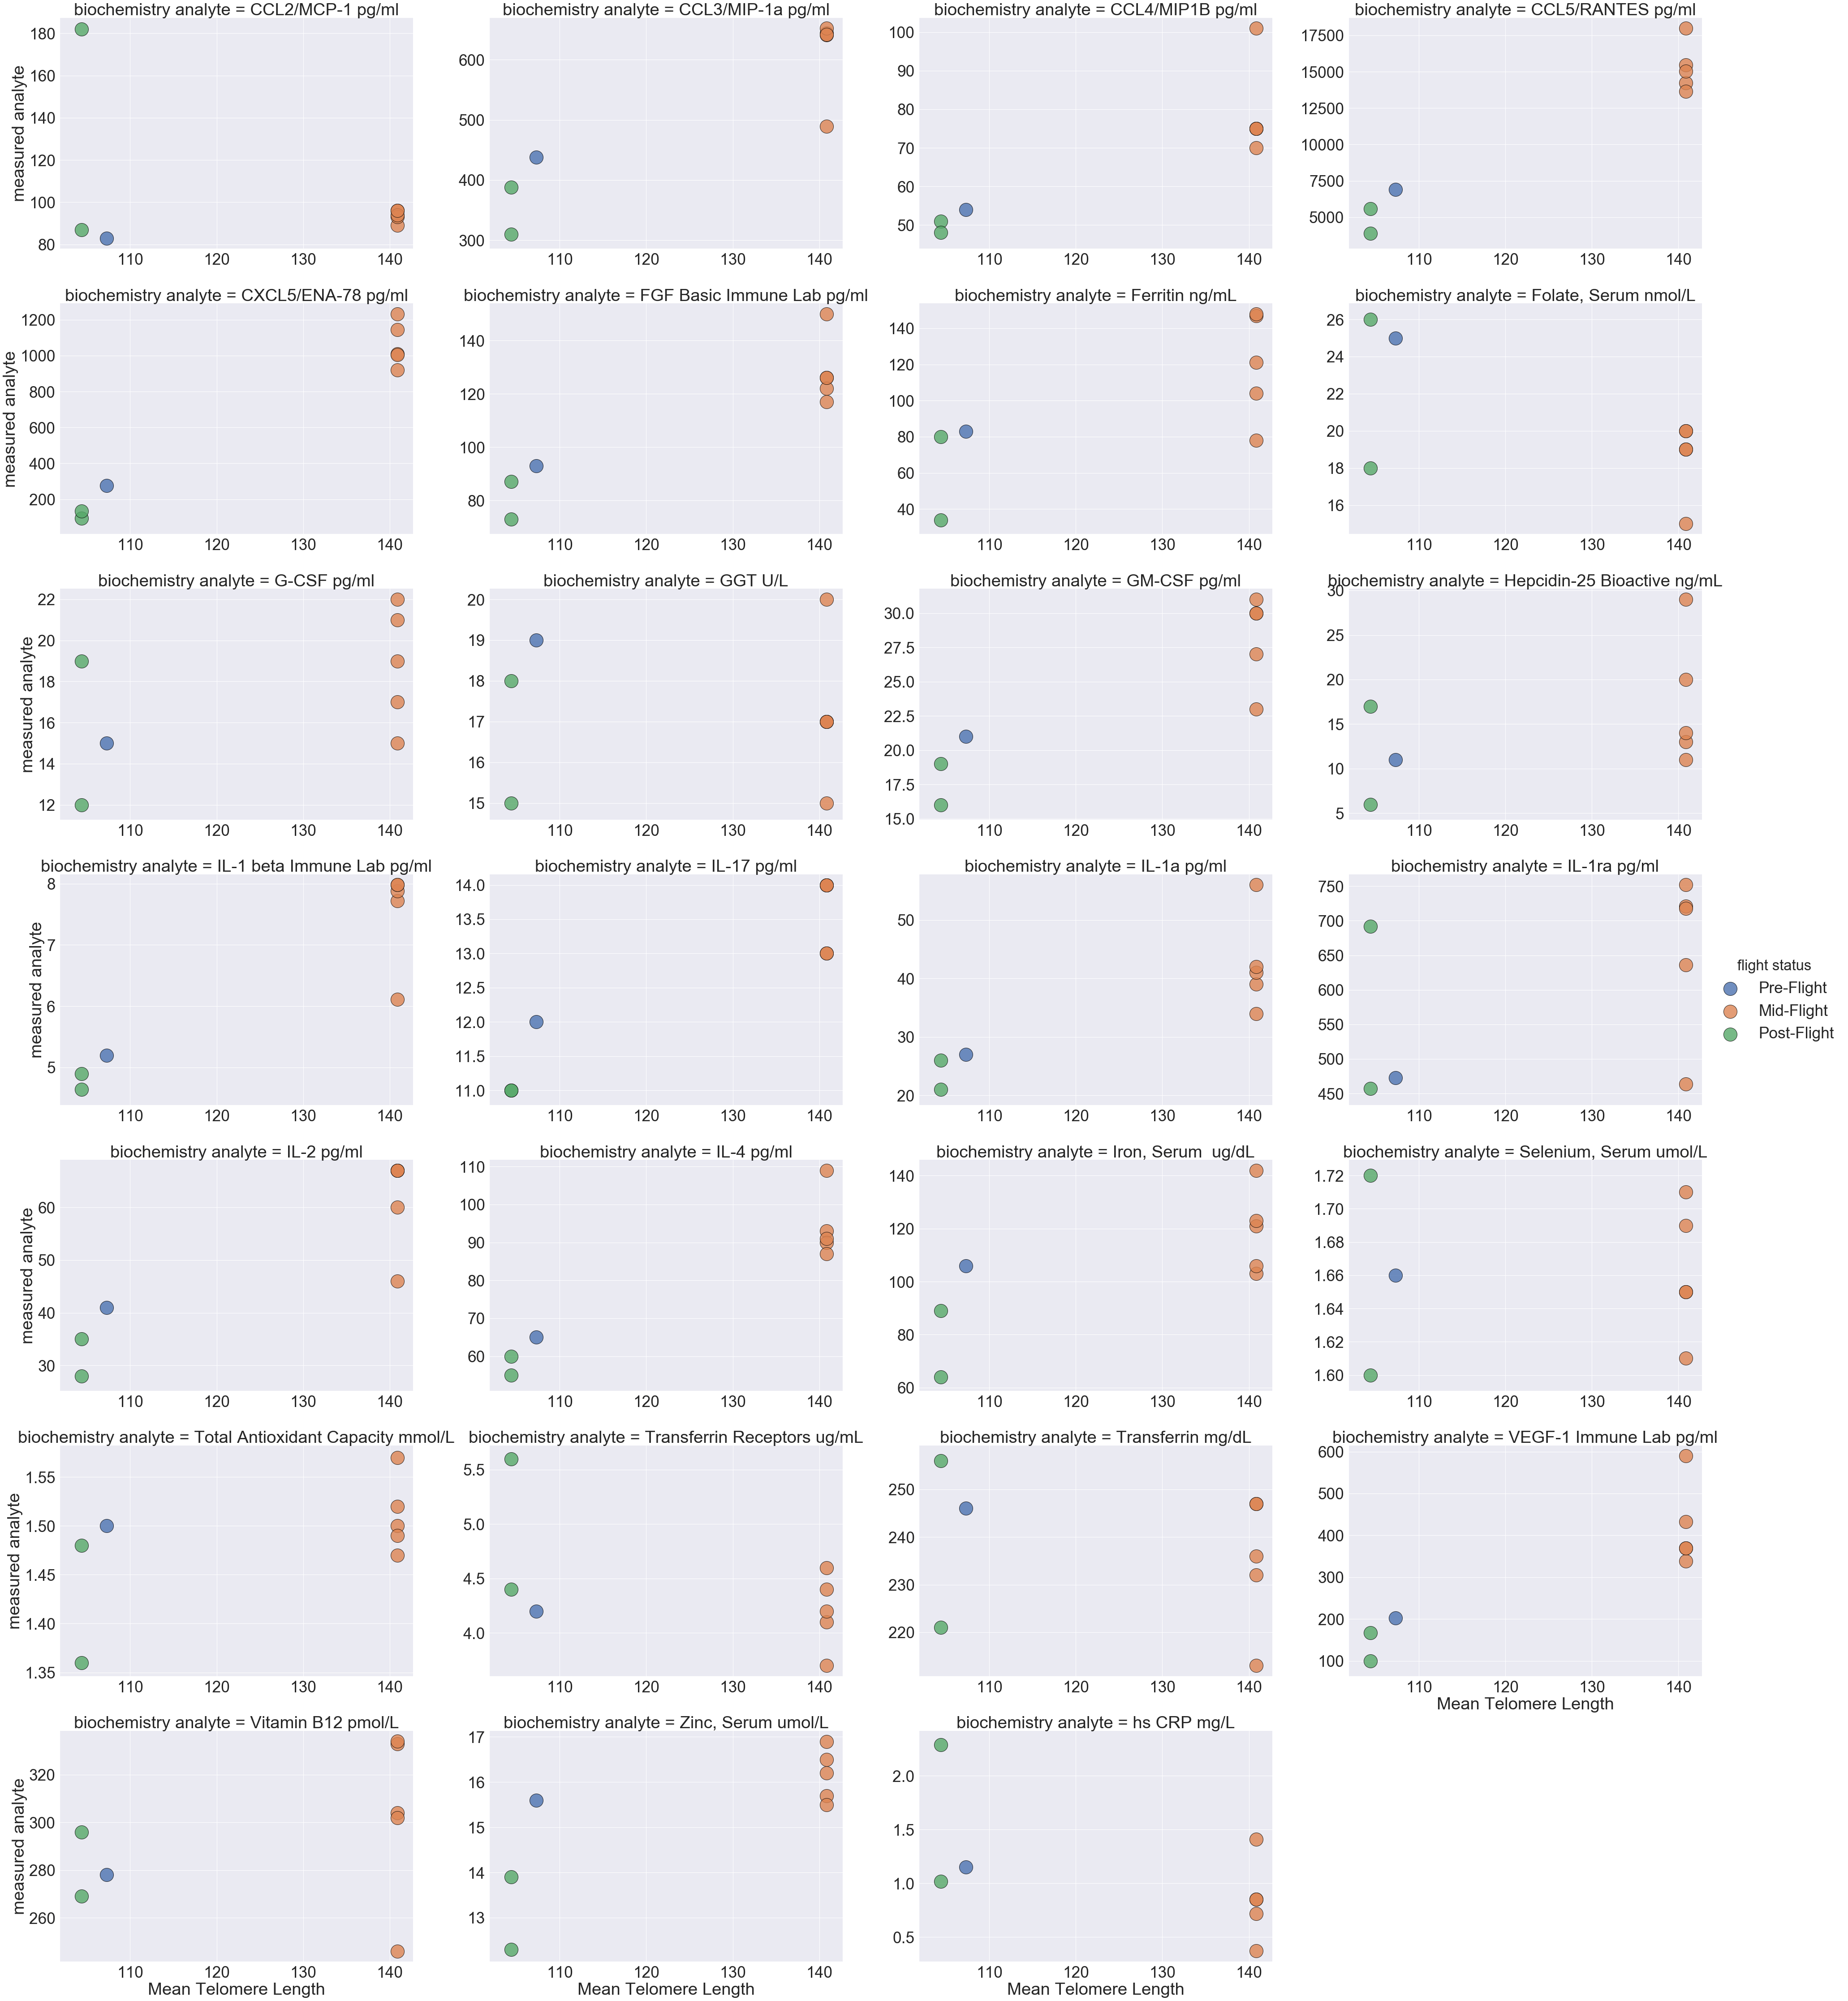

In [18]:
ax = sns.set(font_scale=3.2)
ax = sns.lmplot(x='Mean Telomere Length', y='measured analyte', hue='flight status', 
                col='biochemistry analyte', col_wrap=4,
                data=drop_melt_merge_blood_telos,
                sharey=False,
                sharex=False,
                fit_reg=False,
                hue_order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'],
                scatter_kws={'s':900, 'edgecolor':'black', 'linewidth':1},
                height=9, aspect=1.5,
          )
# plt.tight_layout()
# plt.show()
ax.savefig('graph data/biochemistry correlations/scatterplot correlations blood analytes mean telomere length.png')

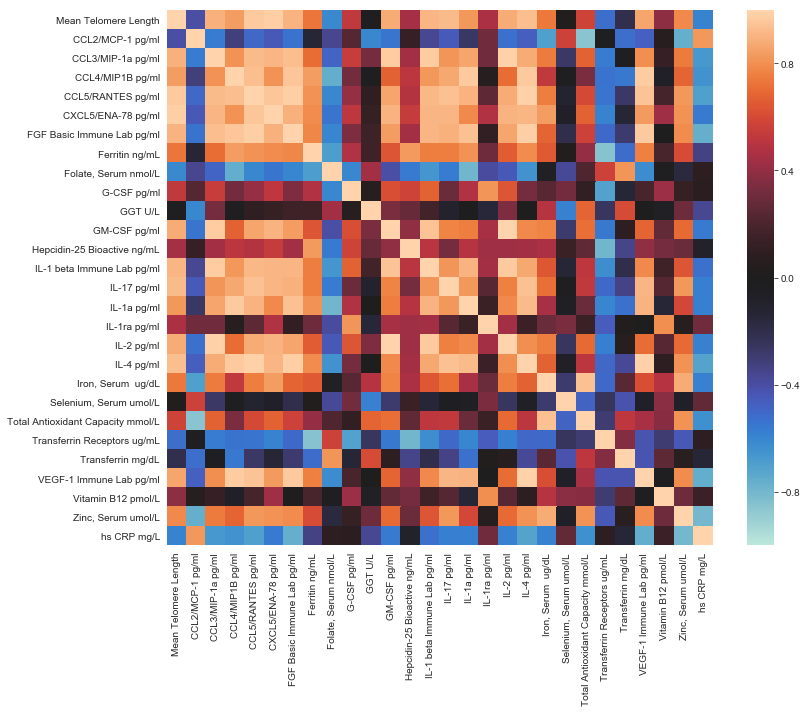

In [26]:
plt.figure(figsize=(12,10))
ax = sns.heatmap(drop_na_pivot_merge_blood_telos.corr(), 
                 vmin=-1, vmax=1, center=0,)
ax.set_xlabel('')
ax.set_ylabel('')
ax.figure.tight_layout()
# sns.set(font_scale=.9)

# plt.savefig('graph data/biochemistry correlations/biochemistry blood corr.png', dpi=400)

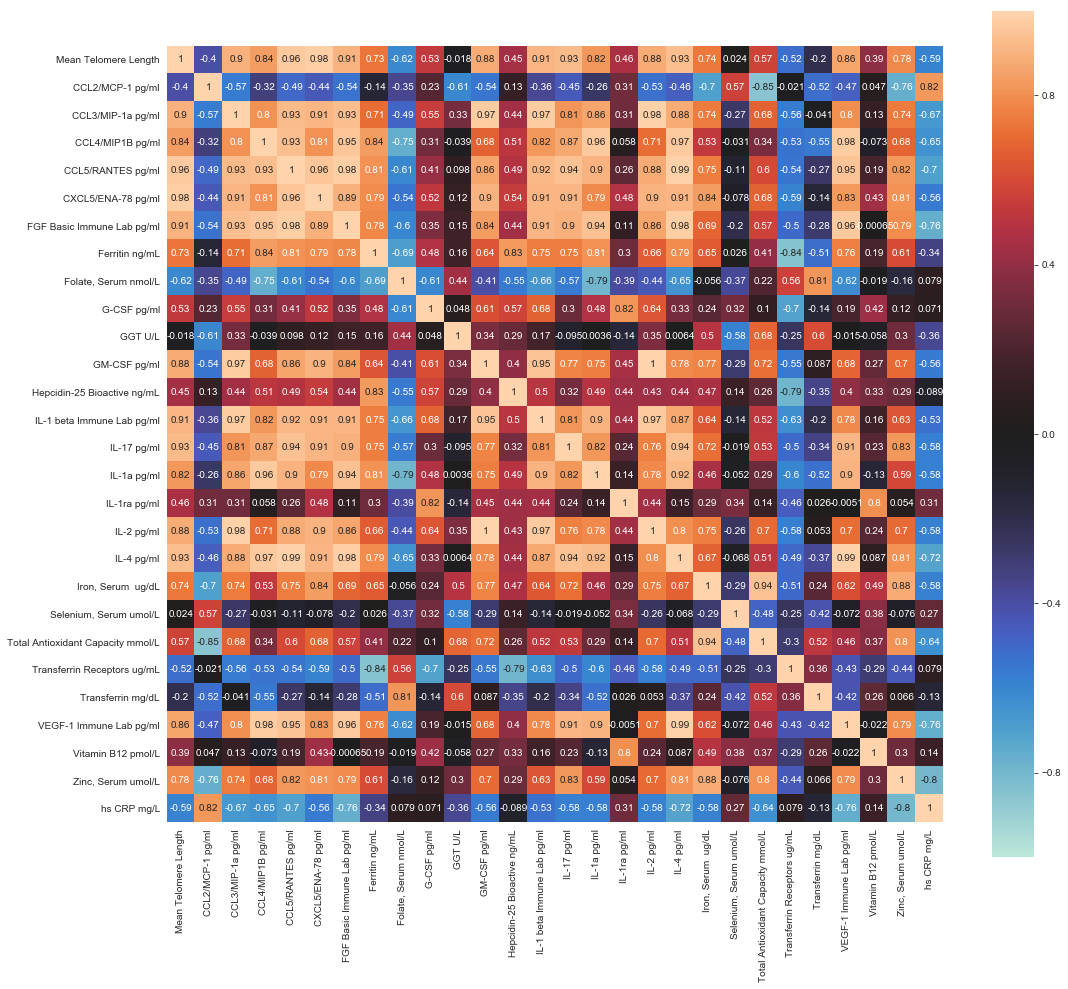

In [30]:
plt.figure(figsize=(16,14))
ax = sns.heatmap(drop_na_pivot_merge_blood_telos.corr(), 
                 vmin=-1, vmax=1, center=0, square=True, annot=True)
ax.set_xlabel('')
ax.set_ylabel('')
ax.figure.tight_layout()

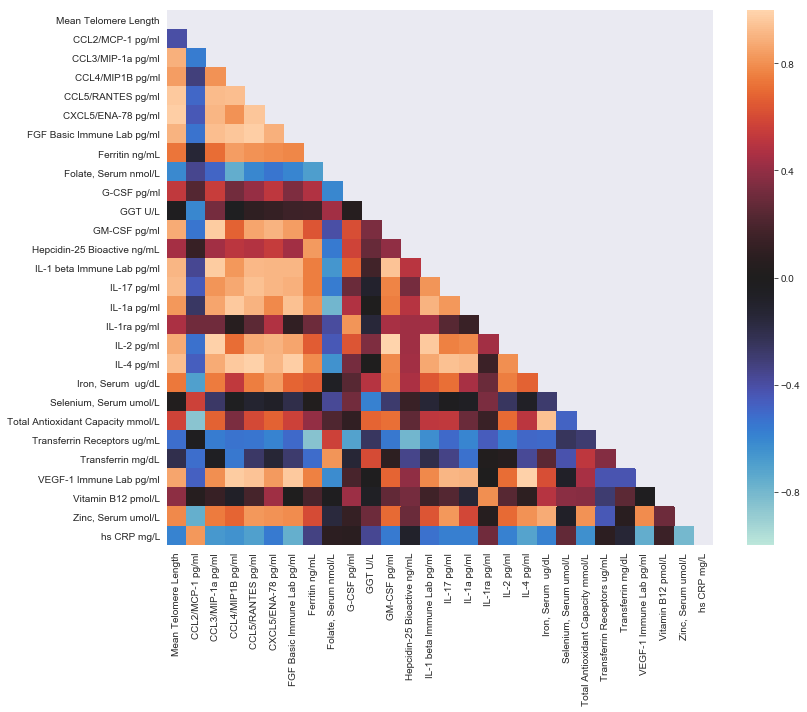

In [23]:
plt.figure(figsize=(12,10))

mask = np.zeros_like(drop_na_pivot_merge_blood_telos.corr())
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(drop_na_pivot_merge_blood_telos.corr(), 
                 vmin=-1, vmax=1, center=0, mask=mask)
ax.set_xlabel('')
ax.set_ylabel('')
ax.figure.tight_layout()
# sns.set(font_scale=.9)

# plt.savefig('graph data/biochemistry correlations/biochemistry blood corr.png', dpi=400)

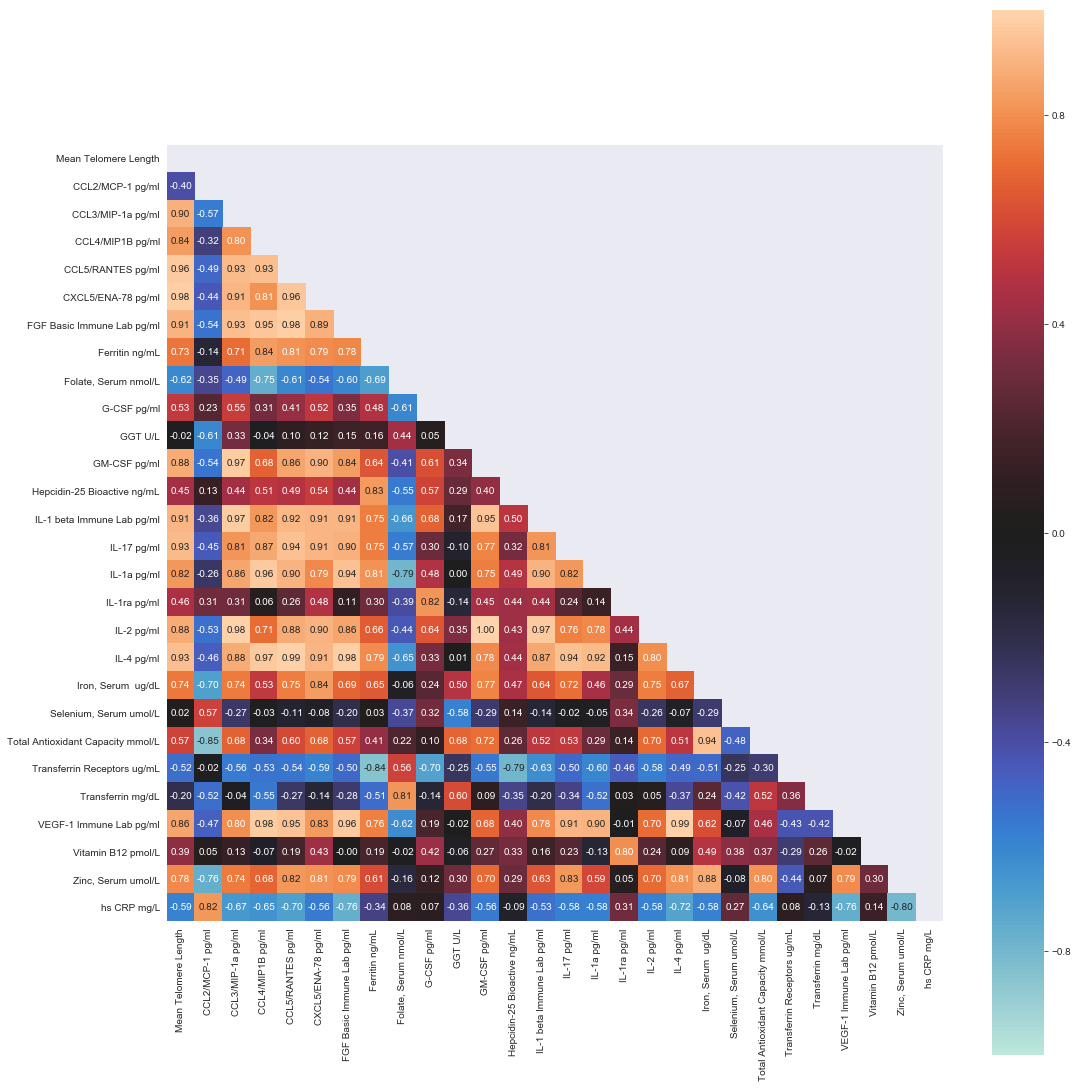

In [37]:
plt.figure(figsize=(16,16))

mask = np.zeros_like(drop_na_pivot_merge_blood_telos.corr())
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(drop_na_pivot_merge_blood_telos.corr(), 
                 vmin=-1, vmax=1, center=0, square=True, 
                 annot=True, mask=mask, fmt=".2f")
ax.set_xlabel('')
ax.set_ylabel('')
ax.figure.tight_layout()
plt.savefig('graph data/test heatmap.png', dpi=400)

In [24]:
beta_groups = merge_grouped_blood_telos.groupby('biochemistry analyte')

beta_groups2 = merge_blood_telos.groupby('biochemistry analyte')

In [25]:
high_corr_tests = {}

for group in list(merge_blood_telos['biochemistry analyte'].unique()):
    
    # number of nas in dataframe
    if beta_groups2.get_group(group).isna().sum().sum() == 0:
#         display(beta_groups.get_group(group))

        if abs(beta_groups2.get_group(group).corr()['telo means'][0]) > 0.7:
            high_corr_tests[group] = beta_groups2.get_group(group).corr()['telo means'][0]
            print(f"{group}: {beta_groups2.get_group(group).corr()['telo means'][0]}")

KeyError: 'telo means'

In [ ]:
# del high_corr_tests['Selenium, Serum umol/L']

In [ ]:
high_corr_df = pd.DataFrame()

for analyte in high_corr_tests:
    df = merge_blood_telos[merge_blood_telos['biochemistry analyte'] == analyte]
    high_corr_df = pd.concat([df, high_corr_df], axis=0)

In [ ]:
print(
len(melt_blood_biochem_data['biochemistry analyte'].unique()),
len(high_corr_df['biochemistry analyte'].unique()))

high_corr_df.head(4)

In [ ]:
ax = sns.catplot(x='flight status', y='measured analyte', data=high_corr_df,
           **{'ci':'sd'}, col='biochemistry analyte', col_wrap=6, kind='bar', sharey=False, height=7, aspect=1)


fig = ax.fig 
    
fig.suptitle(f'Astronaut Blood Biochemistry Analytes of High Correlations w/ Mean Telomere Length (>|0.7|)', fontsize=30, weight='bold')
plt.subplots_adjust(top=0.90)
ax.set_titles(size=20)
ax.set_ylabels(size=20)
ax.set_xlabels(size=20)

plt.savefig('./graph data/biochemistry correlations/Astronaut Blood Biochemistry Analytes of High Correlations with Mean Telomere Length.png')